In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu" # for use on ARM Macs

import jax
print("JAX device:", jax.devices())
jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", True) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan

Metal device set to: Apple M3 Max

systemMemory: 36.00 GB
maxCacheSize: 13.50 GB

JAX device: [CpuDevice(id=0)]


W0000 00:00:1759434016.175133 3286471 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1759434016.193749 3286471 service.cc:145] XLA service 0x10da0aa60 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759434016.193923 3286471 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1759434016.197178 3286471 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1759434016.197231 3286471 mps_client.cc:384] XLA backend will use up to 28990554112 bytes on device 0 for SimpleAllocator.


In [2]:
from jcm.model import Model, get_coords
from jcm.boundaries import boundaries_from_file

realistic_boundaries = boundaries_from_file(
    'jcm/data/bc/t30/clim/boundaries.nc',
    get_coords().horizontal,
)

In [9]:
# default model settings
# use reslistic orography from boundaries file
model = Model(
    orography=realistic_boundaries.orog,
    time_step=60.,
)

# save every month, run for 3 months, turn on averaging so that the last diagnostic is averages of the third month
predictions = model.run(
    save_interval=1,
    total_time=90,
    # add output averaging flag
)

In [10]:
pred_ds = model.predictions_to_xarray(predictions)

In [11]:
print(f"dataset size: {pred_ds.nbytes/1e6:.1f}MB")

dataset size: 330.1MB


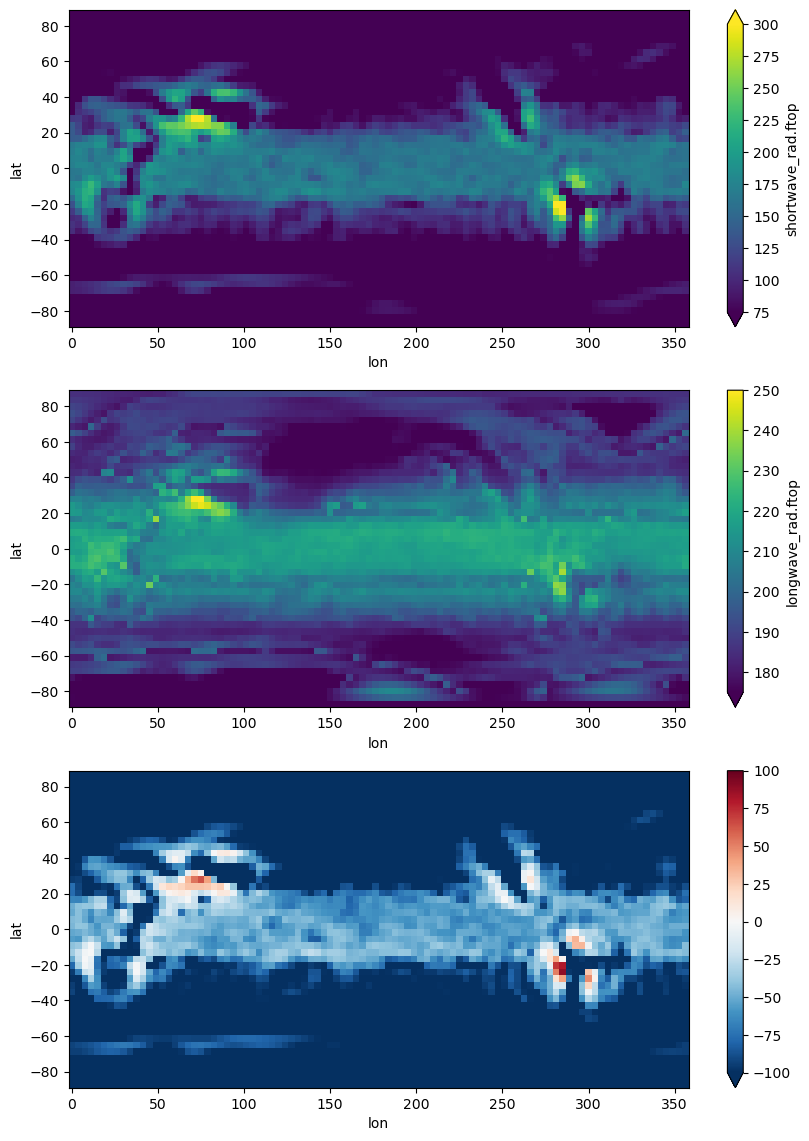

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, figsize=(10,14))
pred_ds['shortwave_rad.ftop'].isel(time=slice(-30,None)).mean(dim='time').T.plot(ax=ax[0],vmin=75,vmax=300)
pred_ds['longwave_rad.ftop'].isel(time=slice(-30,None)).mean(dim='time').T.plot(ax=ax[1],vmin=175,vmax=250)
(pred_ds['shortwave_rad.ftop']-pred_ds['longwave_rad.ftop']).isel(time=slice(-30,None)).mean(dim='time').T.plot(ax=ax[2],cmap='RdBu_r',vmin=-100,vmax=100)

In [13]:
# generate maps of means and variances for the last 30 days of the run

q_mean = pred_ds.isel(time=slice(-30,None)).specific_humidity.mean(dim='time')
q_std = pred_ds.isel(time=slice(-30,None)).specific_humidity.std(dim='time')

t_mean = pred_ds.isel(time=slice(-30,None)).temperature.mean(dim='time')
t_std = pred_ds.isel(time=slice(-30,None)).temperature.std(dim='time')

u_mean = pred_ds.isel(time=slice(-30,None)).u_wind.mean(dim='time')
u_std = pred_ds.isel(time=slice(-30,None)).u_wind.std(dim='time')

v_mean = pred_ds.isel(time=slice(-30,None)).v_wind.mean(dim='time')
v_std = pred_ds.isel(time=slice(-30,None)).v_wind.std(dim='time')

nsp_mean = pred_ds.isel(time=slice(-30,None)).normalized_surface_pressure.mean(dim='time')
nsp_std = pred_ds.isel(time=slice(-30,None)).normalized_surface_pressure.std(dim='time')

phi_mean = pred_ds.isel(time=slice(-30,None)).geopotential.mean(dim='time')
phi_std = pred_ds.isel(time=slice(-30,None)).geopotential.std(dim='time')

# total outgoing radiation at top of atmosphere
TOA_rad = pred_ds['shortwave_rad.ftop']-pred_ds['longwave_rad.ftop']
TOA_rad_mean = TOA_rad.isel(time=slice(-30,None)).mean(dim='time')
TOA_rad_std = TOA_rad.isel(time=slice(-30,None)).std(dim='time')

# relative humidity
rh_mean = pred_ds['humidity.rh'].isel(time=slice(-30,None)).mean(dim='time')
rh_std = pred_ds['humidity.rh'].isel(time=slice(-30,None)).std(dim='time')

# stratiform cloud cover
cloudstr_mean = pred_ds['shortwave_rad.cloudstr'].isel(time=slice(-30,None)).mean(dim='time')
cloudstr_std = pred_ds['shortwave_rad.cloudstr'].isel(time=slice(-30,None)).std(dim='time')

# equivalent specific humidity of clouds
qcloud_mean = pred_ds['shortwave_rad.qcloud'].isel(time=slice(-30,None)).mean(dim='time')
qcloud_std = pred_ds['shortwave_rad.qcloud'].isel(time=slice(-30,None)).std(dim='time')

# precip from convection
precnv_mean = pred_ds['convection.precnv'].isel(time=slice(-30,None)).mean(dim='time')
precnv_std = pred_ds['convection.precnv'].isel(time=slice(-30,None)).std(dim='time')

# precip from large scale condensation
precls_mean = pred_ds['condensation.precls'].isel(time=slice(-30,None)).mean(dim='time')
precls_std = pred_ds['condensation.precls'].isel(time=slice(-30,None)).std(dim='time')


# # save numpy file with means and stds for testing, this is 2MB
import numpy as np
np.savez('jcm/data/test/t30/default_statistics.npz',
    q_mean=q_mean, q_std=q_std,
    t_mean=t_mean, t_std=t_std,
    u_mean=u_mean, u_std=u_std,
    v_mean=v_mean, v_std=v_std,
    nsp_mean=nsp_mean, nsp_std=nsp_std,
    phi_mean=phi_mean, phi_std=phi_std,
    TOA_rad_mean=TOA_rad_mean, TOA_rad_std=TOA_rad_std,
    rh_mean=rh_mean, rh_std=rh_std,
    cloudstr_mean=cloudstr_mean, cloudstr_std=cloudstr_std,
    qcloud_mean=qcloud_mean, qcloud_std=qcloud_std,
    precnv_mean=precnv_mean, precnv_std=precnv_std,
    precls_mean=precls_mean, precls_std=precls_std,
         )